In [30]:
import gc
import sys
sys.path.append('../../../')

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

In [2]:
plt.ioff() # Turn off matplotlib interactive mode. Prevents  memory leakage.

In [3]:
# Load extracted raw signals
raw_signals = np.load('../../../data/STEAD/extracted_raw_signals_subsample_10000.npy')

# Load created waveform images
waveform_imgs = np.load('../../../data/STEAD/created_waveform_images_subsample_10000.npy')

# Load created spectrogram images
spectrogram_imgs = np.load('../../../data/STEAD/created_spectrogram_images_subsample_10000.npy')

# Load extracted raw signals
metadata = pd.read_feather('../../../data/STEAD/extracted_metadata_subsample_10000.feather')
metadata = metadata.reset_index()

In [4]:
spectrogram_imgs.shape

(10000, 200, 300, 3)

In [5]:
waveform_imgs.shape

(10000, 200, 600, 3)

In [6]:
metadata['label'] = [1 if label=='earthquake_local' else 0 for label in metadata['trace_category']]
classifier_labels = metadata['label'].values

In [7]:
classifier_labels

array([1, 1, 1, ..., 0, 0, 0])

In [8]:
earthquakes_indices = np.array(list(metadata[metadata['trace_category']=='earthquake_local'].index))
raw_signals_earthquakes_only = raw_signals[earthquakes_indices]
waveform_imgs_earthquakes_only = waveform_imgs[earthquakes_indices]
spectrogram_imgs_earthquakes_only = spectrogram_imgs[earthquakes_indices]
metadata_earthquakes_only = metadata[metadata['trace_category']=='earthquake_local']

In [328]:
# regressor_target_cols = ['source_magnitude']
# regressor_target_names = ['Source Magnitude']
# regressor_labels = np.array(metadata_earthquakes_only[regressor_target_cols])
# regressor_labels.shape

(5081, 5)

In [598]:
# subsample_indices = np.random.choice(len(spectrogram_imgs), size=2000)
# subsample_imgs = spectrogram_imgs[subsample_indices]
# subsample_metadata = metadata.iloc[subsample_indices]

In [10]:
metadata

,trace_name,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,...,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,chunk,weight_for_subsample,label
0,B084.PB_20111212104350_EV,PB,B084,EH,33.611570,-116.456370,1271.0,800.0,manual,0.55,...,0.5746,63.90,178.5,[15.39999962 15.5 17.10000038],[[3199.]],43:51.3,earthquake_local,1,9.706561e-07,1
1,B086.PB_20080618145426_EV,PB,B086,EH,33.557500,-116.531000,1392.0,800.0,manual,0.59,...,0.5071,56.40,330.6,[45. 46.20000076 46.29999924],[[2230.]],54:27.0,earthquake_local,1,9.706561e-07,1
2,B023.PB_20130513182210_EV,PB,B023,EH,46.111200,-123.078700,177.4,500.0,manual,0.63,...,0.9683,107.61,163.1,[12.60000038 12.10000038 11.19999981],[[3199.]],22:11.5,earthquake_local,1,9.706561e-07,1
3,B011.PB_20120724202107_EV,PB,B011,EH,48.649543,-123.448192,22.0,800.0,manual,0.76,...,0.8950,99.44,82.7,[20.39999962 26.39999962 25. ],[[3199.]],21:08.5,earthquake_local,1,9.706561e-07,1
4,B082.PB_20150914105733_EV,PB,B082,HH,33.598182,-116.596005,1374.8,799.0,autopicker,0.92,...,0.1618,17.99,123.9,[28.79999924 30.29999924 28.70000076],[[1516.]],57:35.0,earthquake_local,1,9.706561e-07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,AMKA.AV_20180115125824_NO,AV,AMKA,BH,51.377100,179.300000,116.0,NaN,None,NaN,...,NaN,NaN,NaN,None,None,2018-01-15 12:58:24,noise,6,4.247619e-06,0
9996,ANM.AK_201012072324_NO,AK,ANM,BH,64.564600,-165.373200,338.0,NaN,None,NaN,...,NaN,NaN,NaN,None,None,2010-12-07 23:24:00,noise,6,4.247619e-06,0
9997,MPK.NN_201508190953_NO,NN,MPK,HH,39.295670,-120.030170,2484.0,NaN,None,NaN,...,NaN,NaN,NaN,None,None,2015-08-19 09:53:00,noise,6,4.247619e-06,0
9998,NAPC.NC_201605150336_NO,NC,NAPC,HN,38.439510,-122.252720,716.0,NaN,None,NaN,...,NaN,NaN,NaN,None,None,2016-05-15 03:36:00,noise,6,4.247619e-06,0


In [385]:
metadata.columns

Index(['trace_name', 'network_code', 'receiver_code', 'receiver_type',
       'receiver_latitude', 'receiver_longitude', 'receiver_elevation_m',
       'p_arrival_sample', 'p_status', 'p_weight', 'p_travel_sec',
       's_arrival_sample', 's_status', 's_weight', 'source_id',
       'source_origin_time', 'source_origin_uncertainty_sec',
       'source_latitude', 'source_longitude', 'source_error_sec',
       'source_gap_deg', 'source_horizontal_uncertainty_km', 'source_depth_km',
       'source_depth_uncertainty_km', 'source_magnitude',
       'source_magnitude_type', 'source_magnitude_author',
       'source_mechanism_strike_dip_rake', 'source_distance_deg',
       'source_distance_km', 'back_azimuth_deg', 'snr_db', 'coda_end_sample',
       'trace_start_time', 'trace_category', 'chunk', 'weight_for_subsample',
       'label'],
      dtype='object')

In [11]:
def image_preprocessing(image, image_size):
    image = tf.image.resize(image, image_size)  # Resize image
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

In [12]:
spectrogram_kwargs = {'image_size' : (300,200)}
waveform_kwargs = {'image_size' : (600,200)}

In [335]:
def format_data(x, y):
    return x, {
        'source_magnitude': y[:, 0], 
        'p_wave_arrival': y[:, 1],
        's_wave_arrival': y[:, 2], e
        'source_distance': y[:, 3], 
        'source_depth': y[:, 4], 
    }

In [353]:
def prepare_datasets(imgs, labels, preproc_func, preproc_func_kwargs, use_scaler=False, batch_size=32):
    # If array has only one dimension, it must be reshaped for input into the scaler
    if labels.ndim == 1:
        labels = labels.reshape(-1, 1) 
        
    X_train, X_test, y_train, y_test = train_test_split(imgs, labels, random_state=0, test_size=0.25)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, test_size=0.25)  

    if use_scaler:
        scaler = RobustScaler()
        y_train = scaler.fit_transform(y_train)
        y_val = scaler.transform(y_val)
        y_test = scaler.transform(y_test)
    
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    
    train_dataset = train_dataset.map(lambda x, y: (preproc_func(x, **preproc_func_kwargs), y))
    val_dataset = val_dataset.map(lambda x, y: (preproc_func(x, **preproc_func_kwargs), y))
    test_dataset = test_dataset.map(lambda x, y: (preproc_func(x, **preproc_func_kwargs), y))
    
    train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    if use_scaler:  
        return train_dataset, val_dataset, test_dataset, scaler
    else:
        return train_dataset, val_dataset, test_dataset

In [354]:
train_dataset_c, val_dataset_c, test_dataset_c = prepare_datasets(imgs=spectrogram_imgs, labels=classifier_labels, preproc_func=image_preprocessing, preproc_func_kwargs=spectrogram_kwargs, batch_size=32)

y_train before scaler: [[4.0000e+00 7.0000e+02 3.4750e+03 2.4635e+02 1.4864e+02]
 [1.0000e+00 7.9900e+02 1.2580e+03 3.6430e+01 1.3090e+01]
 [9.1000e-01 6.9800e+02 7.7800e+02 4.5300e+00 1.3600e+00]]
y_train after scaler: [[ 2.10236220e+00  6.66666667e-03  3.02052039e+00  3.60708057e+00
   1.36225681e+01]
 [-2.59842520e-01  3.36666667e-01  4.70761803e-02 -5.38890827e-02
   4.36770428e-01]
 [-3.30708661e-01  0.00000000e+00 -5.96700644e-01 -6.10219742e-01
  -7.04280156e-01]]
y_test before scaler: [[9.000e-01 7.000e+02 8.950e+02 5.610e+00 1.592e+01]
 [1.150e+00 4.000e+02 6.160e+02 1.533e+01 7.130e+00]
 [1.350e+00 9.000e+02 1.106e+03 1.022e+01 5.060e+00]]
y_test after scaler: [[-0.33858268  0.00666667 -0.43978004 -0.59138472  0.71206226]
 [-0.14173228 -0.99333333 -0.81397532 -0.42186955 -0.14299611]
 [ 0.01574803  0.67333333 -0.15678648 -0.51098709 -0.34435798]]


In [340]:
# Callback to stop model training early if loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    
    mode='min',
    patience=5,                # number of epochs to wait for improvement
    restore_best_weights=True, # restore the best weights once training stops
    verbose=1                 
)

# Callback to reduce learning rate if loss stops improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,                # the factor by which the learning rate will be reduced
    patience=2,                # number of epochs to wait for improvement
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss', 
    save_best_only=True        # save only the best model
)

callbacks = [early_stopping, reduce_lr, checkpoint]

In [47]:
# classifier model
classifier_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')  # 10 output classes
])

In [48]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-6)
classifier_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier_history = classifier_model.fit(train_dataset_c, epochs=2, callbacks=callbacks, validation_data=val_dataset_c)

Epoch 1/2
 15/176 ━━━━━━━━━━━━━━━━━━━━ 1:30 562ms/step - accuracy: 0.5414 - loss: 0.6868

KeyboardInterrupt: 

In [383]:
def plot_training_history(history):
    if 'accuracy' and 'val_accuracy' in history.history.keys():
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
        ax1.plot(history.history['loss'], color='xkcd:cranberry', label='Training loss')
        ax1.plot(history.history['val_loss'], color='xkcd:dusty blue', label='Validation loss')
        ax1.grid(True, alpha=0.2, zorder=5)
        ax1.set_title('Model loss')
        ax1.set_ylabel('Loss (sparse categorical crossentropy)')
        ax1.set_xlabel('Epoch')
        ax1.legend()   
        ax2.plot(history.history['accuracy'], color='xkcd:cranberry', label='Training accuracy')
        ax2.plot(history.history['val_accuracy'], color='xkcd:dusty blue', label='Validation accuracy')
        ax2.grid(True, alpha=0.2, zorder=5)
        ax2.set_title('Model Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend()    
        plt.tight_layout()
        plt.show()
    if 'mae' and 'val_mae' in history.history.keys():
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
        ax1.plot(history.history['loss'], color='xkcd:cranberry', label='Training loss')
        ax1.plot(history.history['val_loss'], color='xkcd:dusty blue', label='Validation loss')
        ax1.grid(True, alpha=0.2, zorder=5)
        ax1.set_title('Model loss')
        ax1.set_ylabel('Loss (sparse categorical crossentropy)')
        ax1.set_xlabel('Epoch')
        ax1.legend()   
        ax2.plot(history.history['mae'], color='xkcd:cranberry', label='Training MAE')
        ax2.plot(history.history['val_mae'], color='xkcd:dusty blue', label='Validation MAE')
        ax2.grid(True, alpha=0.2, zorder=5)
        ax2.set_title('Model MAE')
        ax2.set_ylabel('MAE')
        ax2.set_xlabel('Epoch')
        ax2.legend()    
        plt.tight_layout()
        plt.show()        
    elif 'loss' and 'val_loss' in history.history.keys():
        fig, ax = plt.subplots(1,1,figsize=(5,5))
        ax.plot(history.history['loss'], color='xkcd:cranberry', label='Training loss')
        ax.plot(history.history['val_loss'], color='xkcd:dusty blue', label='Validation loss')
        ax.grid(True, alpha=0.2, zorder=5)
        ax.set_title('Model loss')
        ax.set_ylabel('Loss (sparse categorical crossentropy)')
        ax.set_xlabel('Epoch')
        ax.legend()
        plt.tight_layout()
        plt.show()        

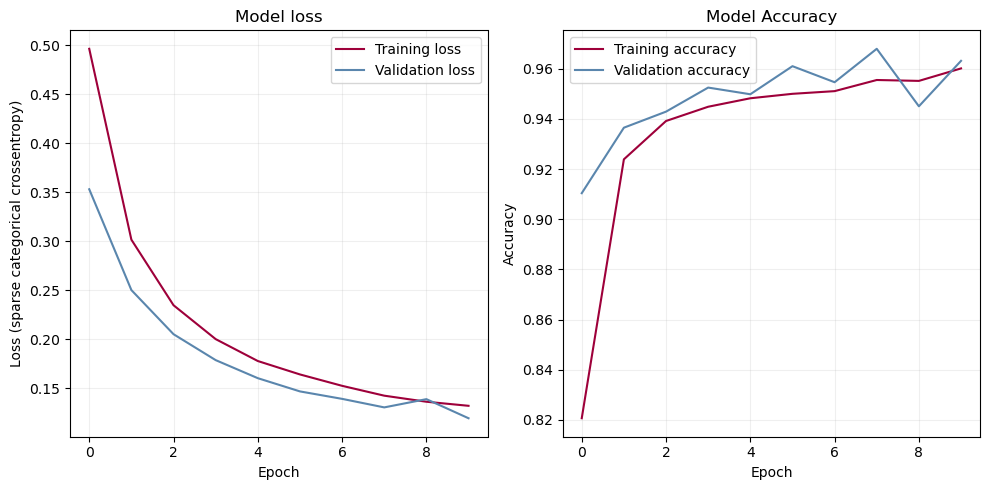

In [581]:
plot_training_history(classifier_history)

In [582]:
def evaluate_classification_model(trained_model, test_dataset):
    # Parse test labels from test dataset
    test_labels = []
    for _, labels in test_dataset:
        test_labels.append(labels.numpy())
    test_labels = np.concatenate(test_labels)
    
    print('Evaluating model on test dataset')    
    print('Finding predicted classes and probabilities')
    predicted_classes = np.argmax(trained_model.predict(test_dataset),axis=-1) # predict the class of each image
    predicted_probs = trained_model.predict(test_dataset) # predict the probability of each image belonging to a class
    
    accuracy = accuracy_score(test_labels, predicted_classes)
    precision = precision_score(test_labels, predicted_classes)
    recall = recall_score(test_labels, predicted_classes)
    f1 = f1_score(test_labels ,predicted_classes)
    print(f'Model accuracy: {accuracy}\n Model precision: {precision}\n Model recall: {recall}\n Model F1 score: {f1}')

    # Create confusion matrix
    print('Building confusion matrix')
    cm = confusion_matrix(test_labels, predicted_classes) # compare target values to predicted values and show confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not earthquake','earthquake'])

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(test_labels, predicted_classes)
    roc_auc = auc(fpr, tpr)  

    # Plot accuracy history, confusion matrix, roc curve
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))  
    disp.plot(cmap='Blues', ax=ax1, values_format='')
    ax1.set_title('Classification CNN Results')
    ax2.plot(fpr, tpr, color='xkcd:cranberry', label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='lightgray', linestyle='--')  # diagonal line (random classifier)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.grid(True, alpha=0.2, zorder=5)
    plt.tight_layout()
    plt.show()
    

Evaluating model on test dataset
Finding predicted classes and probabilities
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step
Model accuracy: 0.9612
 Model precision: 0.9804719283970708
 Model recall: 0.9428794992175273
 Model F1 score: 0.9613083366573594
Building confusion matrix


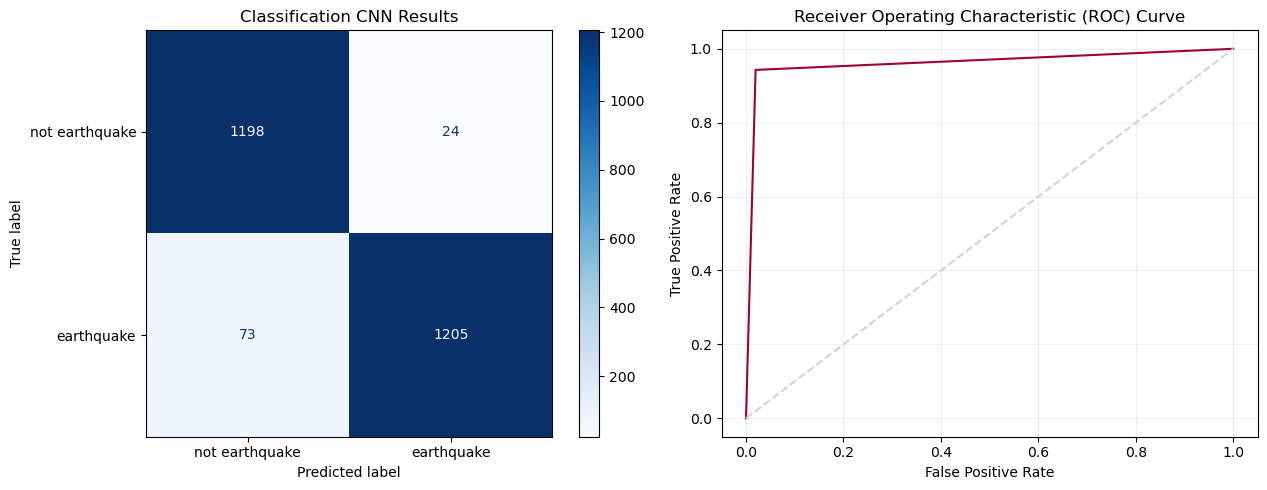

In [583]:
evaluate_classification_model(classifier_model, test_dataset_c)

In [20]:
waveform_imgs_earthquakes_only.shape

(5081, 200, 600, 3)

In [345]:
input_shape = (waveform_imgs_earthquakes_only.shape[2], waveform_imgs_earthquakes_only.shape[1], waveform_imgs_earthquakes_only.shape[3])
inputs = tf.keras.layers.Input(shape=input_shape)

x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation = 'relu', padding = 'same')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation = 'relu', padding = 'same')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Separate heads for each target variable
head_1 = tf.keras.layers.Dense(1, name='source_magnitude')(x)
head_2 = tf.keras.layers.Dense(1, name='p_wave_arrival')(x)
head_3 = tf.keras.layers.Dense(1, name='s_wave_arrival')(x) 
head_4 = tf.keras.layers.Dense(1, name='source_distance')(x)
head_5 = tf.keras.layers.Dense(1, name='source_depth')(x) 

# Create model with multiple outputs
regressor_model = tf.keras.Model(inputs=inputs, outputs=[head_1, head_2, head_3, head_4, head_5])
regressor_model.compile(
    optimizer='adam',
    loss={'source_magnitude': 'mse', 'p_wave_arrival': 'mse', 's_wave_arrival': 'mse', 'source_distance': 'mse', 'source_depth': 'mse'},
    metrics={'source_magnitude': 'mse', 'p_wave_arrival': 'mae', 's_wave_arrival': 'mae', 'source_distance': 'mae', 'source_depth': 'mae'}
)
    
regressor_history = regressor_model.fit(train_dataset_r, epochs=50, callbacks=callbacks, validation_data=val_dataset_r)

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 536s 6s/step - loss: 58611.4922 - p_wave_arrival_loss: 682.2533 - p_wave_arrival_mae: 12.4013 - s_wave_arrival_loss: 32549.9395 - s_wave_arrival_mae: 58.5427 - source_depth_loss: 689.1227 - source_depth_mae: 18.9196 - source_distance_loss: 14528.3057 - source_distance_mae: 47.5545 - source_magnitude_loss: 10159.2080 - source_magnitude_mse: 10172.9336 - val_loss: 24.9505 - val_p_wave_arrival_loss: 0.5313 - val_p_wave_arrival_mae: 0.5633 - val_s_wave_arrival_loss: 9.7041 - val_s_wave_arrival_mae: 1.5610 - val_source_depth_loss: 2.7867 - val_source_depth_mae: 2.0397 - val_source_distance_loss: 5.7282 - val_source_distance_mae: 2.1857 - val_source_magnitude_loss: 6.1847 - val_source_magnitude_mse: 4.7093 - learning_rate: 0.0010
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 517s 6s/step - loss: 20.7765 - p_wave_arrival_loss: 0.8152 - p_wave_arrival_mae: 0.5873 - s_wave_arrival_loss: 9.7049 - s_wave_arrival_mae: 1.3751 - source_depth_loss: 1.7591 - source_depth_

In [177]:
regressor_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding = 'same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Conv2D(64, kernel_size=(5, 5), activation = 'relu', padding = 'same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(len(regressor_target_names))
])

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
regressor_model.compile(optimizer=opt, loss='mse', metrics=['mae'])
regressor_history = regressor_model.fit(train_dataset_r, epochs=20, callbacks=callbacks, validation_data=val_dataset_r)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - loss: 168.4195 - mae: 3.5765 - val_loss: 0.5523 - val_mae: 0.5406 - learning_rate: 0.0010
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - loss: 0.5689 - mae: 0.5697 - val_loss: 0.5515 - val_mae: 0.5407 - learning_rate: 0.0010
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - loss: 0.5615 - mae: 0.5638 - val_loss: 0.5506 - val_mae: 0.5409 - learning_rate: 0.0010
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - loss: 0.5451 - mae: 0.5563 - val_loss: 0.5495 - val_mae: 0.5411 - learning_rate: 0.0010
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - loss: 0.5371 - mae: 0.5548 - val_loss: 0.5483 - val_mae: 0.5414 - learning_rate: 0.0010
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


In [392]:
def evaluate_regression_model(trained_model, test_dataset, target_variable_name, scaler=None):
    test_labels = []
    for images, labels in test_dataset:
        test_labels.append(np.array(labels))
    test_labels = np.concatenate(test_labels)
    
    print('Evaluating model on test dataset')
    test_results = trained_model.evaluate(test_dataset, verbose=1)
    print(f'Test data MSE: {test_results[0]}')
    print(f'Test data MAE: {test_results[1]}')
    
    print('Getting predictions')
    predicted = trained_model.predict(test_dataset)
    
    if scaler:
        test_labels = scaler.inverse_transform(test_labels)
        predicted = scaler.inverse_transform(predicted)
        print(predicted)
    
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    plot_max = max(test_labels.max(), predicted.max())
    plot_min = min(-0.5, test_labels.min(), predicted.min())
    ax.scatter(test_labels, predicted, color='xkcd:dusty blue', alpha=0.25)
    ax.plot([plot_min*0.9,plot_max*1.1], [plot_min*0.9,plot_max*1.1], color='black', linestyle='--')
    ax.set_ylabel('Predicted Value',fontsize=14)
    ax.set_xlabel('Observed Value',fontsize=14)
    ax.set_title(f'{target_variable_name}')
    ax.set_xlim([plot_min*0.9, plot_max*1.1])
    ax.set_ylim([plot_min*0.9, plot_max*1.1])
    ax.grid(True, alpha=0.2, zorder=5)
    plt.tight_layout()
    plt.show()

In [393]:
def build_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae']):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding = 'same'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation = 'relu', padding = 'same'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(0.35),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    return model

In [ ]:
labels = np.array(metadata_earthquakes_only['source_magnitude'])
train_dataset_mag, val_dataset_mag, test_dataset_mag = prepare_datasets(imgs=spectrogram_imgs_earthquakes_only, labels=labels, preproc_func=image_preprocessing, preproc_func_kwargs=waveform_kwargs, use_scaler=False, batch_size=32)
model_magnitude = build_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_magnitude_history = model_magnitude.fit(train_dataset_mag, epochs=20, callbacks=callbacks, validation_data=val_dataset_mag)
evaluate_regression_model(model_magnitude, test_dataset_mag, 'Source Magnitude', scaler=None)
plot_training_history(model_magnitude_history)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - loss: 0.7579 - mae: 0.6333 - val_loss: 1.2126 - val_mae: 0.8505 - learning_rate: 1.0000e-05
Epoch 2/20
40/90 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - loss: 0.4437 - mae: 0.4687

In [ ]:
labels = np.array(metadata_earthquakes_only['p_wave_arrival'])
train_dataset_pwave, val_dataset_pwave, test_dataset_pwave = prepare_datasets(imgs=waveform_imgs_earthquakes_only, labels=labels, preproc_func=image_preprocessing, preproc_func_kwargs=waveform_kwargs, use_scaler=False, batch_size=32)
model_pwave = build_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_pwave_history = model_pwave.fit(train_dataset_pwave, epochs=20, callbacks=callbacks, validation_data=val_dataset_pwave)
evaluate_regression_model(model_pwave, test_dataset_pwave, 'P-Wave Arrival', scaler=None)
plot_training_history(model_pwave_history)

In [ ]:
labels = np.array(metadata_earthquakes_only['s_wave_arrival'])
train_dataset_swave, val_dataset_swave, test_dataset_swave = prepare_datasets(imgs=waveform_imgs_earthquakes_only, labels=labels, preproc_func=image_preprocessing, preproc_func_kwargs=waveform_kwargs, use_scaler=False, batch_size=32)
model_swave = build_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_swave_history = model_swave.fit(train_dataset_swave, epochs=20, callbacks=callbacks, validation_data=val_dataset_swave)
evaluate_regression_model(model_swave, test_dataset_swave, 'S-Wave Arrival', scaler=None)
plot_training_history(model_swave_history)

In [ ]:
labels = np.array(metadata_earthquakes_only['source_distance_km'])
train_dataset_dist, val_dataset_dist, test_dataset_dist = prepare_datasets(imgs=spectrogram_imgs_earthquakes_only, labels=labels, preproc_func=image_preprocessing, preproc_func_kwargs=waveform_kwargs, use_scaler=False, batch_size=32)
model_distance = build_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_distance_history = model_distance.fit(train_dataset_dist, epochs=20, callbacks=callbacks, validation_data=val_dataset_dist)
evaluate_regression_model(model_distance, test_dataset_dist, 'Source-Receiver Distance (km)', scaler=None)
plot_training_history(model_distance_history)

In [ ]:
labels = np.array(metadata_earthquakes_only['source_depth_km'])
train_dataset_depth, val_dataset_depth, test_dataset_depth = prepare_datasets(imgs=spectrogram_imgs_earthquakes_only, labels=labels, preproc_func=image_preprocessing, preproc_func_kwargs=waveform_kwargs, use_scaler=False, batch_size=32)
model_depth = build_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_depth_history = model_swave.fit(train_dataset_depth, epochs=20, callbacks=callbacks, validation_data=val_dataset_depth)
evaluate_regression_model(model_depth, test_dataset_depth, 'Source Depth (km)', scaler=None)
plot_training_history(model_depth_history)

TODO
1. XX RobustScaler for regression target variables
2. XX Train simple regression CNN to predict the 3 outputs using the scaled targets
3. XX If that doesn't work, train a separate model for the Magnitude prediction and then use one model for the p-wave and s-wave variables
4. XX If it does work, try adding source depth and source distance as target variables as well
6. XXX If nothing works well, go back to orignal plan of training 4 separate models
7. Refactor LSTM code
8. Train LSTM models
9. (extra) Try a pretrained ResNet backbone and a pretrained VisionTransformer backbone for just the classification task

